司天数据预处理+测光

In [39]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt

from tqdm import tqdm

from pathlib import Path
BASE = Path('.').resolve().parent

DATADIR = BASE / 'data' / 'st001-20230525-test'
DATADIR.exists()

MYDATADIR = BASE / 'my_data' / 'hm3'
MYDATADIR.mkdir(parents=True, exist_ok=True)

In [5]:
bias_fpath_lst = list(DATADIR.glob('st001-bias-20230525-*.fit'))
flat_fpath_lst = list(DATADIR.glob('st001-flat-20230525-*.fit'))
img_fpath_lst = list(DATADIR.glob('st001-M101-20230525-*.fit'))

def gen_shape_mask(fits_lst, target_shape=(6388, 9576), tag=None):
    mask = []
    for idx, fits_path in tqdm(
            enumerate(fits_lst),
            total=len(fits_lst),
            desc=tag,
    ):
        try:
            data = fits.getdata(fits_path)
            if data.shape != target_shape:
                mask.append(False)
            else:
                mask.append(True)
        except:
            mask.append(False)
    return mask


bias_mask = gen_shape_mask(bias_fpath_lst, target_shape=(6388, 9576), tag='bias')
bias_fpath_lst = [bias_fpath_lst[i] for i in range(len(bias_fpath_lst)) if bias_mask[i]]
print(f'bias: {len(bias_fpath_lst):10d}')

flat_mask = gen_shape_mask(flat_fpath_lst, target_shape=(6388, 9576), tag='flat')
flat_fpath_lst = [flat_fpath_lst[i] for i in range(len(flat_fpath_lst)) if flat_mask[i]]
print(f'flat: {len(flat_fpath_lst):10d}')

img_mask = gen_shape_mask(img_fpath_lst, target_shape=(6388, 9576), tag='image')
img_fpath_lst = [img_fpath_lst[i] for i in range(len(img_fpath_lst)) if img_mask[i]]
print(f'img:  {len(img_fpath_lst) :10d}')

bias: 100%|██████████| 20/20 [00:03<00:00,  6.29it/s]


bias:         10


flat: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


flat:         10


image: 100%|██████████| 110/110 [00:31<00:00,  3.44it/s]

img:         100


叠加平场

In [6]:
assert len(bias_fpath_lst) > 0, 'No bias fits file found!'
bias_lst = []
N_bias_ctr = 0
for bias_fpath in tqdm(
        bias_fpath_lst,
        total=len(bias_fpath_lst),
        desc='reading bias',
):
    try:
        bias_lst.append(fits.getdata(bias_fpath))
        N_bias_ctr += 1
    except:
        continue

# collect to get an 3d array
bias_cube = np.array(bias_lst)
del bias_lst
print(f'bias shape: {bias_cube.shape}')

bias = np.nanmedian(bias_cube, axis=0)  
# bias_var = np.nanvar(bias_cube, axis=0) # read noise
del bias_cube
print(f'stacked bias shape: {bias.shape}')

reading bias: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


bias shape: (10, 6388, 9576)
stacked bias shape: (6388, 9576)


show bias

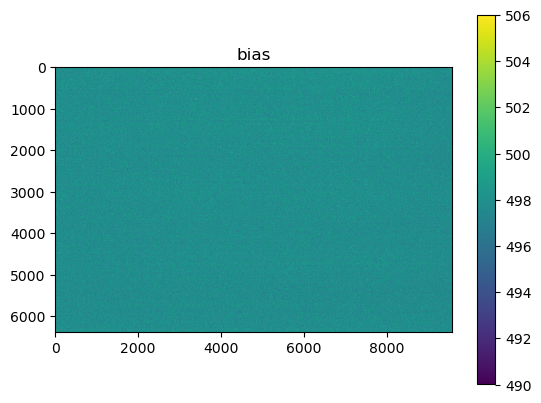

In [19]:
def func_show(img, pmin=5, pmax=95, title=''):
    plt.figure()
    vmin = np.percentile(img, pmin)
    vmax = np.percentile(img, pmax)
    plt.imshow(img, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(title)
    plt.show()
    plt.close()

func_show(bias, title='bias')

In [15]:
flat_lst = []
N_flat_ctr = 0

for flat_fpath in tqdm(
        flat_fpath_lst,
        total=len(flat_fpath_lst),
        desc='reading flat',
):
    try:
        flat_lst.append(fits.getdata(flat_fpath) - bias)
        N_flat_ctr += 1
    except:
        continue

# collect to get an 3d array
flat_cube = np.array(flat_lst)
del flat_lst
print(f'flat shape: {flat_cube.shape}')

flat_median_arr = np.median(flat_cube, axis=(1,2))
for i in range(flat_cube.shape[0]):
    flat_cube[i] = flat_cube[i] / flat_median_arr[i]

flat = np.median(flat_cube, axis=0)

reading flat:   0%|          | 0/10 [00:00<?, ?it/s]

reading flat: 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


flat shape: (10, 6388, 9576)


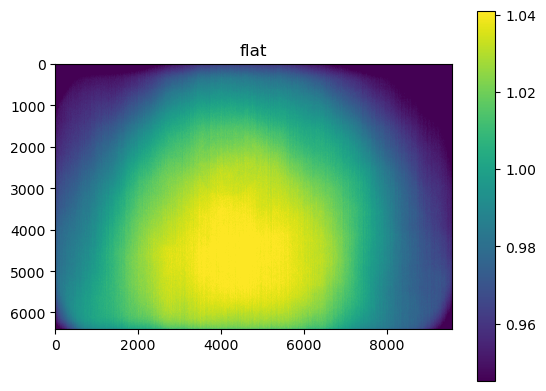

In [20]:
func_show(flat, title='flat')

图像处理

对每张图像，img = (img_raw - bias) / flat

In [17]:
def process_img(img, bias, flat):
    return (img - bias) / flat

首先处理单张图像（homework3 @huang）

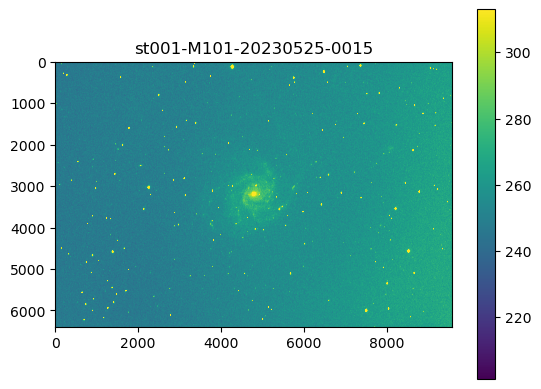

In [22]:
img_fpath0 = img_fpath_lst[0]
img = process_img(fits.getdata(img_fpath0), bias, flat)

func_show(img, title=img_fpath0.stem)

图像背景还是不均匀（可能月光？），再减一个背景

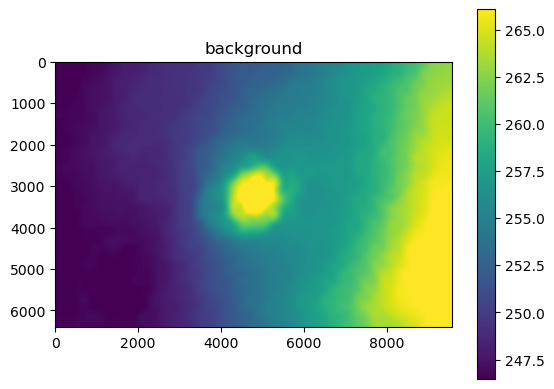

In [70]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(img, (200, 200), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

func_show(bkg.background, title='background')

M101也被当做了背景，但对恒星孔径测光是好的

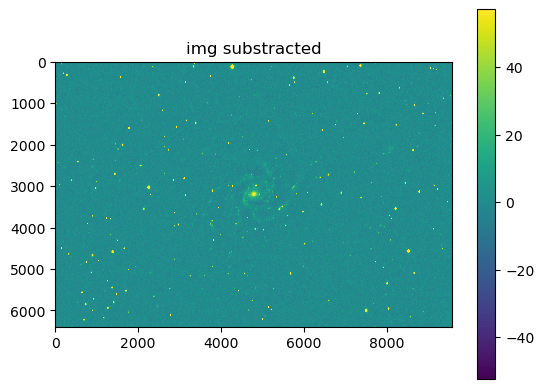

In [71]:
img_clean = img - bkg.background

func_show(img_clean, title='img substracted')

检查星点大小：直径~40pix

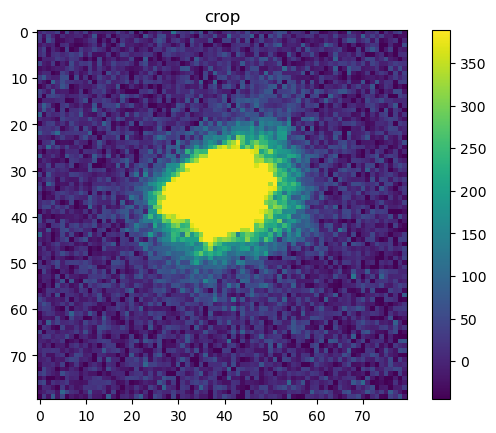

In [79]:
func_show(img_clean[5800:5880, 700:780], title='crop')

保存到文件

In [44]:
header = fits.getheader(img_fpath0)
img_fpath0
fits.writeto(MYDATADIR / img_fpath0.name, data=img_clean, header=header, overwrite=True)
print('saved to', MYDATADIR / img_fpath0.name)

saved to /home/zheng/Documents/PIA2023a/my_data/hm3/st001-M101-20230525-0015.fit


使用sex测光

In [98]:
SEX_WORKSPACE = BASE / 'sex' / 'hm3'
SEX_WORKSPACE.mkdir(exist_ok=True, parents=True)
!echo $SEX_WORKSPACE
!cd $SEX_WORKSPACE
# copy default config file to current dir
!cp $BASE/software/sextractor-2.25.0/config/default.* $SEX_WORKSPACE
!ls $SEX_WORKSPACE

with open(SEX_WORKSPACE / 'default.sex', 'r') as sex_in:
    sex_lines = sex_in.readlines()
with open(SEX_WORKSPACE / 'mine.sex', 'w') as sex_out:
    for line in sex_lines:
        if line.startswith('CATALOG_NAME'):
            line = line[:17] + '{:<14s}'.format('mine.cat') + line[31:]
        if line.startswith('PARAMETERS_NAME'):
            line = line[:17] + '{:<14s}'.format('mine.param') + line[31:]
        if line.startswith('PHOT_APERTURES'):
            # aperture diameter from 20pix to 60pix step 5 pix
            arg_str = ','.join([str(d) for d in range(20, 65, 5)])
            line = line[:17] + '{:<14s}'.format(arg_str) + line[31:]
            # line = line[:17] + '{:<14s}'.format('40') + line[31:]
        if line.startswith('PIXEL_SCALE'):
            line = line[:17] + '{:<14s}'.format('0') + line[31:]
        sex_out.write(line)


with open(SEX_WORKSPACE / 'default.param', 'r') as sex_in:
    sex_lines = sex_in.readlines()
with open(SEX_WORKSPACE / 'mine.param', 'w') as sex_out:
    for line in sex_lines:
        if line[1:26].strip() in (
            'NUMBER', 
            'FLUX_ISO', 
            'FLUXERR_ISO', 
            'MAG_ISO', 
            'MAGERR_ISO', 
            'FLUX_APER', 
            'FLUXERR_APER', 
            'MAG_APER', 
            'MAGERR_APER', 
            'FLUX_BEST', 
            'FLUXERR_BEST', 
            'MAG_BEST', 
            'MAGERR_BEST', 
            'BACKGROUND', 
            'THRESHOLD', 
            'X_IMAGE', 
            'Y_IMAGE', 
            'ALPHA_J2000', 
            'DELTA_J2000', 
        ):
            line = ' ' + line[1:25] + '#' + line[26:]   # un-comment
        sex_out.write(line)

/home/zheng/Documents/PIA2023a/sex/hm3
default.conv  default.nnw  default.param  default.sex  mine.param  mine.sex


In [104]:
fpath_with_wcs = SEX_WORKSPACE / (img_fpath0.stem + '_wcs')
!/usr/local/astrometry/bin/solve-field --cpulimit 60 --resort --scale-units arcsecperpix --scale-low 0.2 --scale-high 0.5 --no-plots --overwrit --dir $SEX_WORKSPACE --out $fpath_with_wcs $img_fpath0

Reading input file 1 of 1: "/home/zheng/Documents/PIA2023a/data/st001-20230525-test/st001-M101-20230525-0015.fit"...
Extracting sources...
simplexy: found 1120 sources.
Reading sort column "FLUX"
Sorting sort column
mmapping input file
Copying table header.
Writing row 0
Done
augment-xylist.c:1398:augment_xylist Failed to open output file /home/zheng/Documents/PIA2023a/sex/hm3//home/zheng/Documents/PIA2023a/sex/hm3/st001-M101-20230525-0015_wcs.axy
 system: No such file or directory


run sex!

In [99]:
!cd $SEX_WORKSPACE && sex $img_fpath0 -c mine.sex

> 
----- SExtractor 2.25.0 started on 2023-06-15 at 03:07:21 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for st001-M101-20230525-0015.fit
----- Measuring from: st001-M101-20230525-0015.fit
      "st001-M101-20230525" / no ext. header / 9576x6388 / 16 bits (integers)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up background map at line:  832
> Setting up background map at line:  896
> Setting up background map

fix WCS using astrometery

In [101]:
!/usr/local/astrometry/bin/solve-field --cpulimit 60 --resort --scale-units arcsecperpix --scale-low 0.2 --scale-high 0.5 --no-plots --overwrit 

Reading input file 1 of 1: "mine.cat"...
ERROR: Image type not recognized: Unknown image type "["cannot open `mine.cat' (No such file or directory)"]"
Traceback (most recent call last):
  File "/usr/local/astrometry/lib/python/astrometry/util/image2pnm.py", line 298, in main
    convert_image(options.infile, options.outfile,
  File "/usr/local/astrometry/lib/python/astrometry/util/image2pnm.py", line 242, in convert_image
    raise RuntimeError(errstr)
RuntimeError: Image type not recognized: Unknown image type "["cannot open `mine.cat' (No such file or directory)"]"
augment-xylist.c:591:backtick Failed to run command: /usr/local/astrometry/bin/image2pnm --infile mine.cat --uncompressed-outfile /tmp/tmp.uncompressed.SDIYHo --outfile /tmp/tmp.ppm.6sc1Yo --ppm --mydir /usr/local/astrometry/bin/solve-field
 ioutils.c:568:run_command_get_outputs Command failed: return value 255
